# Math 4383 Project
### Zachary Koenig, Colin Crippen

In [51]:
!pip install matplotlib

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import csv

In [53]:
# --- Load the 8x8 digits dataset ---
digits = load_digits()

# The dataset contains 8x8 images and their corresponding digit labels.
# X contains image data and y contains the target labels.
IMAGES = digits.images      # Shape: (num_images, 8, 8)
LABELS = digits.target      # Shape: (num_images,)

# --- Data Preprocessing ---

# 1. Flatten the images:
#    Convert each 8x8 image into a 1D array of 64 pixels.
num_images = IMAGES.shape[0]
flattened_images = IMAGES.reshape(num_images, -1)   # Now shape is (num_images, 64)

# 2. Normalize the inputs:
#    The pixel values in the digits dataset are in the range 0-16.
#    Dividing by 16 scales them to the range [0, 1].
normalized_flat_images = flattened_images / 16.0

# 3. One-Hot Encode the Labels:
#    There are 10 classes (digits 0-9), so create one-hot encoded vectors.
num_classes = 10
labels_onehot = np.eye(num_classes)[LABELS]

# --- Split into Training and Verification (Validation) Sets ---
# For example, reserve 20% of the data for validation
image_train_set, image_validatoin_set, labels_train_set, labels_validation_set = train_test_split(
    normalized_flat_images, labels_onehot, test_size=0.2, random_state=4651
)

# Verify the shapes
print("Training set shape:", image_train_set.shape, labels_train_set.shape)  # Should show ~80% of the samples
print("Validation set shape:", image_validatoin_set.shape, labels_validation_set.shape)      # Should show ~20% of the samples
print("One-hot encoded y shape:", labels_onehot.shape)    # Expected: (num_samples, 10)

Training set shape: (1437, 64) (1437, 10)
Validation set shape: (360, 64) (360, 10)
One-hot encoded y shape: (1797, 10)


To enable nonlinear function representation, we'll use the "Sigmoid" activation function

### Sigmoid Function:

$\sigma(x) = \Large\frac{1}{1 + e^{-x}}$

(where $x$ in this program is the weighted sum of the inputs plus the bias from the layer just processed)

- Squashes any real input into the interval $(0,1)$.
- Smooth and differentiable everywhere, which makes gradient‑based learning possible.

### Sigmoid Derivative:
$\sigma'(x) = \sigma(x)\,\bigl(1 - \sigma(x)\bigr)$

(where $x$ in this program is the weighted sum of the inputs plus the bias at the layer from the forward pass)

- Simple closed‑form in terms of $σ(x).$
- Used during backprop to propagate error gradients through the nonlinearity.

### Softmax Function
**Mathematical form:**  

$
\mathrm{softmax}(\mathbf{z})_i
= \Large\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$

(where)

### Safe Softmax Function
**Mathematical form (for a vector $\mathbf{z}\in\mathbb{R}^K$):**

$
\mathrm{softmax}(\mathbf{z})_i
= \Large\frac{e^{z_i - \max_j (z_j)}}
       {\sum_{k=1}^K e^{z_k - \max_j (z_j)}}
$


##### Risks of Standard Softmax:
- **Numerical overflow**  
   - If any $z_i$ is large $(e.g.\ \ z_i > 700)$, then $e^{z_i}$ can overflow to $\infty$.  
   - Subtracting $max_j (z_j)$ ensures the largest exponent is $e^0 = 1$, keeping all values in a safe range.

- **Numerical underflow**  
   - If all $z_i$ are very negative, $e^{z_i}$ can underflow to $0$.  
   - Centering by $max_j (z_j)$ prevents all exponentials from collapsing to $0$, preserving meaningful probability ratios.

##### Benefit of Safe Softmax
- Converts raw scores into a probability distribution over $K$ classes (they sum to 1).
- Subtracting $max_j (z_j)​$  ensures numerical stability.

In [54]:
# --- Activation functions and their derivatives ---

def sigmoid(x):
    """Compute the sigmoid activation."""
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """Compute the derivative of the sigmoid function."""
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)

def softmax(x):
    """Computes the softmax function."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return e_x / e_x.sum(axis=1, keepdims=True)

In [55]:
# --- Hyperparameters ---
input_layer_size = 8 * 8   # 64 inputs, one per pixel
hidden_layer_size = 64       # You can adjust this
output_layer_size = 10       # 10 classes for digits 0-9

learning_rate = 0.1
epochs = 10_000

In [ ]:
class NeuralNet:
    def __init__(self, save_name, input_layer_size, hidden_layer_size, output_layer_size, activ_func = sigmoid, activ_func_der = sigmoid_deriv):
        # --- Initialize Weights and Biases ---
        np.random.seed(42)  # For reproducibility
        self.save_name = save_name
        # Layer sizes
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size

        self.activation_function = activ_func
        self.activation_function_derivative = activ_func_der
        
        # Weights initialization
        self.input_layer_weights = np.random.randn(self.input_layer_size, self.hidden_layer_size) * 0.01
        self.input_layer_biases = np.zeros((1, self.hidden_layer_size))
        self.hidden_layer_weights = np.random.randn(self.hidden_layer_size, self.output_layer_size) * 0.01
        self.hidden_layer_biases = np.zeros((1, self.output_layer_size))
        
    def forward(self, data):
        """Forward pass through the network."""
        self.Z1 = np.dot(data, self.input_layer_weights) + self.input_layer_biases
        self.A1 = self.activation_function(self.Z1)  # Activation for hidden layer
        self.Z2 = np.dot(self.A1, self.hidden_layer_weights) + self.hidden_layer_biases
        self.A2 = softmax(self.Z2)  # Apply softmax activation in the output layer
        return self.A2
    
    def backward(self, data, target, learning_rate=0.01):
        """Backward pass: update weights and biases using gradients."""
        m = data.shape[0]  # Number of training examples

        # Calculate gradients for output layer (using softmax cross-entropy derivative)
        dZ2 = self.A2 - target  # Softmax cross-entropy derivative
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Calculate gradients for hidden layer (using sigmoid derivative)
        dA1 = np.dot(dZ2, self.hidden_layer_weights.T)
        dZ1 = dA1 * self.activation_function_derivative(self.A1)
        dW1 = np.dot(data.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.update_weights(dW1, dW2, learning_rate)
        self.update_biases(db1, db2, learning_rate)
    
    def update_weights(self, dW1, dW2, learning_rate):
        """Update weights using the gradients."""
        self.input_layer_weights -= learning_rate * dW1
        self.hidden_layer_weights -= learning_rate * dW2
        
    def update_biases(self, db1, db2, learning_rate):
        """Update biases using the gradients."""
        self.input_layer_biases -= learning_rate * db1
        self.hidden_layer_biases -= learning_rate * db2

    def predict(self, data):
        """Make predictions using the trained network."""
        return np.argmax(self.forward(data), axis=1)
    
    def save_progress(self):
        # Save the trained weights and biases to disk
        np.save('W1_' + self.save_name + '.npy', self.input_layer_weights)
        np.save('b1_' + self.save_name + '.npy', self.input_layer_biases)
        np.save('W2_' + self.save_name + '.npy', self.hidden_layer_weights)
        np.save('b2_' + self.save_name + '.npy', self.hidden_layer_biases)

### Hidden‐Layer Forward Pass
**Equations:**

$
Z^{[1]} = X\,W^{[1]} + b^{[1]},\quad
A^{[1]} = \sigma\bigl(Z^{[1]}\bigr)
$

### Output‐Layer Forward Pass (Training)
**Equations:**  

$
Z^{[2]} = A^{[1]}\,W^{[2]} + b^{[2]},\quad
A^{[2]} = \sigma\bigl(Z^{[2]}\bigr)
$


# Cross‑Entropy Loss

**Mathematical form:**  
$
\mathcal{L} = -\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K y_{i,k}\,\log\bigl(A^{[2]}_{i,k} + \epsilon\bigr)
$

where $A^{[2]}_{i,k}$ is the output from the network

#### Why add a small constant $\epsilon$ for numerical stability

1. **Avoid $\log(0)\to -\infty$**  
   - If $A^{[2]}_{i,k}=0$, then $\log(0)$ is undefined.  
   - Adding $\epsilon$ ensures $\log\bigl(A^{[2]}_{i,k} + \epsilon\bigr)$ remains finite.

2. **Prevent NaNs and infinities in loss computation**  
   - Keeps the computed loss a real number even when predictions are exactly zero.

3. **Stable backpropagation**  
   - Ensures gradients remain well‑defined, avoiding infinite or undefined gradient values.

In [57]:
def calculate_loss(output):
    # Compute Cross-Entropy Loss (adding a small constant for numerical stability)
    return -np.mean(np.sum(labels_train_set * np.log(output + 1e-8), axis=1))

### Backpropagation Gradients
**Output layer gradients:**  

$
dZ^{[2]} = A^{[2]} - Y,\quad
dW^{[2]} = \frac{(A^{[1]})^\top\,dZ^{[2]}}{m},\quad
db^{[2]} = \frac{1}{m}\sum_i dZ^{[2]}_{i,\ast}
$

**Hidden layer gradients:**  

$
dA^{[1]} = dZ^{[2]}\,(W^{[2]})^\top,\quad
dZ^{[1]} = dA^{[1]}\,\circ\,\sigma'\bigl(Z^{[1]}\bigr)
$

$
dW^{[1]} = \frac{X^\top\,dZ^{[1]}}{m},\quad
db^{[1]} = \frac{1}{m}\sum_i dZ^{[1]}_{i,\ast}
$

### Parameter Updates
**Gradient descent step:**  

$
W^{[\ell]} \leftarrow W^{[\ell]} - \alpha\,dW^{[\ell]},\quad
b^{[\ell]} \leftarrow b^{[\ell]} - \alpha\,db^{[\ell]}
\quad(\ell=1,2)
$

In [58]:
def accuracy_check(nn, pred_output, epoch, loss):
    # Training Accuracy (using the training forward pass already computed)
    train_preds = np.argmax(pred_output, axis=1)
    true_train_labels = np.argmax(labels_train_set, axis=1)
    train_accuracy = np.mean(train_preds == true_train_labels)

    # Validation: perform a forward pass over the validation set.
    validation_output = nn.forward(image_validatoin_set)
    val_preds = np.argmax(validation_output, axis=1)
    true_val_labels = np.argmax(labels_validation_set, axis=1)
    val_accuracy = np.mean(val_preds == true_val_labels)

    print(f"Epoch {epoch}: loss = {loss:.4f}, train acc = {train_accuracy:.4f}, val acc = {val_accuracy:.4f}")
    return (epoch, loss, train_accuracy, val_accuracy)

In [59]:
# --- Lists to Save Progress Data ---
progress_data = []  # Each element: (epoch, loss, training set accuracy, validation set accuracy)

def training_loop(neural_network, saveName: str):

    for epoch in range(epochs):

        prediction_output = neural_network.forward(image_train_set)
        
        loss = calculate_loss(prediction_output)
        
        neural_network.backward(image_train_set, labels_train_set)

        # During training, sample 100 times to compute and record training accuracy and loss
        if epoch % max(1, epochs // 100) == 0:
            progress_data.append(accuracy_check(neural_network, prediction_output, epoch, loss))

    neural_network.save_progress()
    # Save progress data to CSV
    csv_filename = 'training_progress' + saveName + '.csv'
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["epoch", "loss", "train_accuracy", "val_accuracy"])
        for record in progress_data:
            writer.writerow(record)

#neural_network = NeuralNet("sig", image_train_set.shape[1], 64, labels_train_set.shape[1])
neural_network = NeuralNet("sig", image_train_set.shape[1], 64, labels_train_set.shape[1])
training_loop(neural_network, "sig")

Epoch 0: loss = 0.7013, train acc = 0.1051, val acc = 0.0833
Epoch 100: loss = 2.1060, train acc = 0.1051, val acc = 0.0833
Epoch 200: loss = 2.2714, train acc = 0.1051, val acc = 0.0833
Epoch 300: loss = 2.2964, train acc = 0.1051, val acc = 0.0833
Epoch 400: loss = 2.3003, train acc = 0.1051, val acc = 0.0833
Epoch 500: loss = 2.3007, train acc = 0.1051, val acc = 0.0833
Epoch 600: loss = 2.3007, train acc = 0.1051, val acc = 0.0833
Epoch 700: loss = 2.3005, train acc = 0.1051, val acc = 0.0833
Epoch 800: loss = 2.3003, train acc = 0.1051, val acc = 0.0833
Epoch 900: loss = 2.3001, train acc = 0.1051, val acc = 0.0833
Epoch 1000: loss = 2.2999, train acc = 0.1051, val acc = 0.0833
Epoch 1100: loss = 2.2997, train acc = 0.1051, val acc = 0.0833
Epoch 1200: loss = 2.2994, train acc = 0.1051, val acc = 0.0833
Epoch 1300: loss = 2.2992, train acc = 0.1051, val acc = 0.0833
Epoch 1400: loss = 2.2989, train acc = 0.1051, val acc = 0.0833
Epoch 1500: loss = 2.2986, train acc = 0.1051, val a

In [69]:
def test_single_image():
    # --- Display and Test One Image ---
    # Select a random image from the validation set
    idx = np.random.randint(0, image_validatoin_set.shape[0])  # Fix: Correctly get the index
    img = image_validatoin_set[idx].reshape(8, 8)
    label = np.argmax(labels_validation_set[idx])

    # Save the image array to a file.
    np.save("test.npy", img)

    plt.imshow(img, cmap='gray')
    plt.title(f"Training Image - Digit: {label}")
    plt.axis('off')
    plt.show()

    # Load the test image.
    test_image = np.load('test.npy')

    # Flatten the image so that it has shape (1, 64)
    flat_test_image = test_image.reshape(1, -1)

    # Perform the forward pass to get the softmax output (probabilities)
    prediction_probs = neural_network.forward(flat_test_image)

    # Get the predicted class (index of the maximum probability)
    predicted_class = np.argmax(prediction_probs)

    # Calculate the confidence (probability of the predicted class)
    probability = np.max(prediction_probs)

    print("Predicted class:", predicted_class)
    print("Confidence: {:.2f}%".format(probability * 100))  # Correct confidence


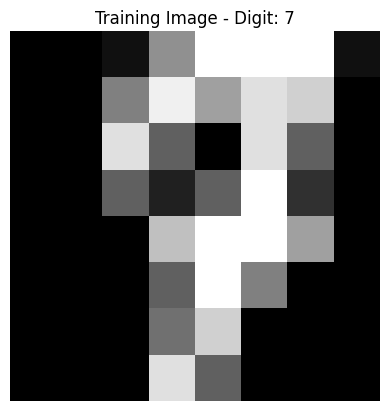

Predicted class: 7
Confidence: 49.61%
Test set accuracy: 72.78%


In [71]:
# --- Perform Predictions on the Validation Set Using the Loaded Weights ---
predictions = neural_network.predict(image_validatoin_set)  # Fix the spelling of 'validation'

# Calculate the accuracy of the model on the test set.
# Convert the one-hot encoded labels to integer labels.
true_labels = np.argmax(labels_validation_set, axis=1)

# Test a single image (this is just for visualization/testing purposes)
test_single_image()

# Accuracy Calculation
accuracy = np.mean(predictions == true_labels)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))


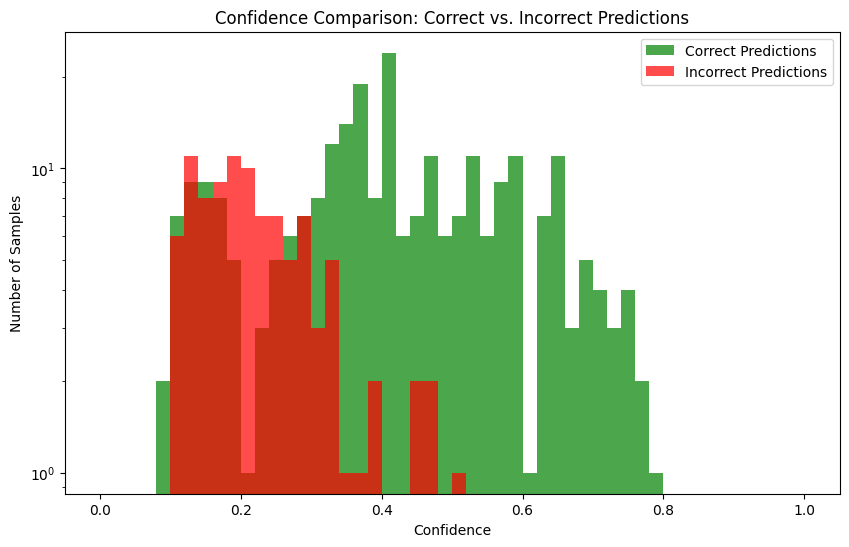

In [65]:
def plot_confidence_comparison(probabilities, true_labels, bins=20):
    """
    Plots histograms comparing the confidence scores for correctly vs.
    incorrectly classified samples.
    
    Parameters:
        probabilities (np.ndarray): A 2D array of shape (n_samples, n_classes) 
            containing the predicted probabilities (e.g., outputs of softmax).
        true_labels (np.ndarray): A 1D array of true labels (integers) of shape (n_samples,).
            If your labels are in one-hot format, convert them using np.argmax.
        bins (int): Number of bins for the histogram.
    """
    # Compute predicted labels (choose the class with the highest probability).
    predictions = np.argmax(probabilities, axis=1)
    
    # Compute the confidence for each prediction as the maximum probability.
    confidences = np.max(probabilities, axis=1)

    # Create consistent bin edges from 0 to 1.
    bin_edges = np.linspace(0, 1, bins + 1)
    
    # Separate confidence scores based on whether the prediction was correct.
    correct_confidences = confidences[predictions == true_labels]
    incorrect_confidences = confidences[predictions != true_labels]
    
    # Plot histograms for the two groups.
    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=bin_edges, alpha=0.7, label='Correct Predictions', color='green')
    plt.hist(incorrect_confidences, bins=bin_edges, alpha=0.7, label='Incorrect Predictions', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Number of Samples')
    plt.yscale("log")
    plt.title('Confidence Comparison: Correct vs. Incorrect Predictions')
    plt.legend()
    plt.show()

# Get the predicted probabilities (outputs of softmax)
predictions_output = neural_network.forward(image_validatoin_set)

# Plot the confidence comparison using the true labels
true_labels = np.argmax(labels_validation_set, axis=1)  # Convert one-hot to integer labels
plot_confidence_comparison(predictions_output, true_labels, bins=50)


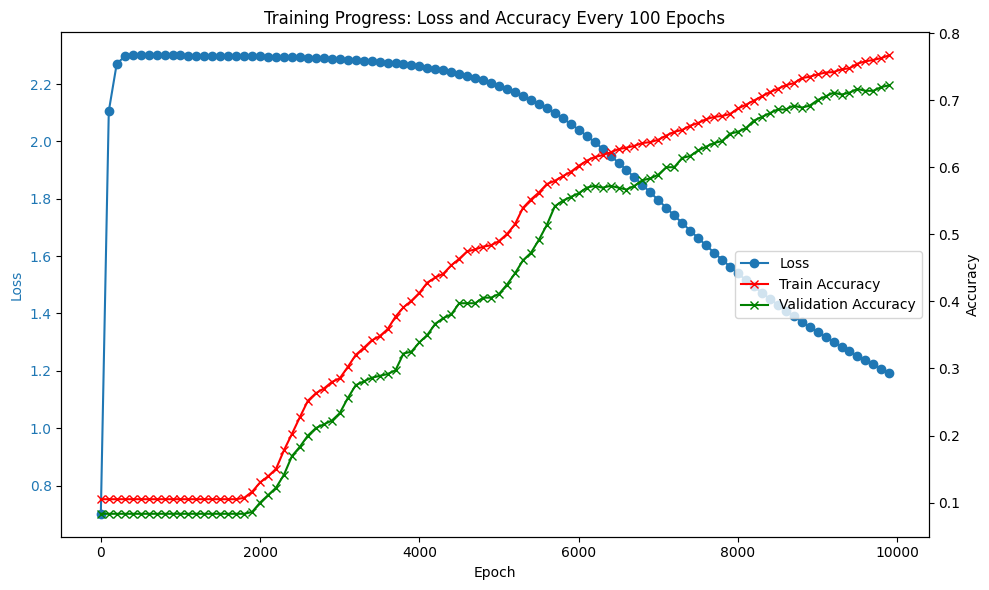

In [64]:
def plot_training_progress(csv_filepath):
    """
    Reads the CSV with training progress data (epoch, loss, training accuracy, validation accuracy)
    and plots the loss and accuracy curves. Loss is plotted on the left y-axis, while accuracy (both training
    and validation) is plotted on the right y-axis with training accuracy in red and validation accuracy in green.
    """
    epochs_list = []
    loss_list = []
    train_acc_list = []
    val_acc_list = []

    with open(csv_filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            epochs_list.append(float(row["epoch"]))
            loss_list.append(float(row["loss"]))
            train_acc_list.append(float(row["train_accuracy"]))
            val_acc_list.append(float(row["val_accuracy"]))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    color_loss = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss)
    ax1.plot(epochs_list, loss_list, marker='o', color=color_loss, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)

    # Create a second y-axis for the accuracies
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='black')
    ax2.plot(epochs_list, train_acc_list, marker='x', color='red', label='Train Accuracy')
    ax2.plot(epochs_list, val_acc_list, marker='x', color='green', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes and display
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Training Progress: Loss and Accuracy Every 100 Epochs')
    plt.tight_layout()
    plt.show()

plot_training_progress("training_progress_sig.csv")